<a href="https://colab.research.google.com/github/kbdev20/Convolution_Crusaders/blob/main/Convolution_Crusaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Automated Vessel Detection in Satellite Imagery__

## 0. Setting Up the Project Environment

Welcome to the ship detection project! To ensure a smooth and consistent experience for all collaborators, we have organized all necessary data into a shared Google Drive folder. Here’s a step-by-step guide on setting up the project.

### Access the Shared Folder

Navigate to the shared folder [data4](https://drive.google.com/drive/folders/1hYe7QkSBkYvLi3skmBat5-dw1-QkhA_d?usp=sharing) on Google Drive.
This folder contains all the required data and resources to run this project.
Add the Folder to Your Drive:

* Right-click on the ‘data4’ folder.
* Select ‘Add shortcut to Drive’.
* Choose ‘My Drive’ and click ‘Add Shortcut’.

### Mount Google Drive in Colab:

In the first code cell of this notebook, run the script to mount your Google Drive. Follow the on-screen instructions to authorize access.

Once mounted, you can seamlessly access all files from the ‘data4’ folder directly within this Colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Library Installation

The second cell installs two external libraries, 'scikit-learn' and 'ultralytics,' using the __'pip install'__ command. These libraries are essential for specific functionalities within the notebook and are not part of the default Python environment.

* __scikit-learn:__
  * scikit-learn is a popular machine learning library in Python, providing tools for data analysis and modeling. It includes various modules for classification, regression, clustering, and more.
* __ultralytics:__
  * Ultralytics is a repository containing the YOLOv8 implementation. It is utilized for training and inference with YOLO (You Only Look Once) models. This library simplifies tasks related to YOLO model deployment and experimentation.

Installing these libraries ensures that the notebook has access to the required functionalities for machine learning tasks, particularly when working with YOLOv8 models and employing machine learning algorithms provided by scikit-learn.

In [ ]:
!pip install scikit-learn
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.7/645.7 kB 7.5 MB/s eta 0:00:00


Now, you are all set! Each cell is well-documented to guide you through the various stages of the project. Execute the cells in sequence.

## 1. Preparing the Data

In this section, we focus on the crucial task of preparing the dataset for training our YOLOv8 model. Effective data preparation is fundamental to the success of the model, influencing its ability to learn and generalize patterns from the provided images. We begin by exploring the dataset's structure and visualizing some sample images to gain insights into the data distribution. The primary goal is to convert the dataset into a format compatible with YOLOv8 requirements.

### File Extraction (Already Executed)

_Note:_ This cell is for informational purposes and was executed once to extract the dataset files into the Google Drive folder. The dataset is now readily available in the ‘dataa’ directory for access and usage. There is no need to re-run this extraction process, and you can proceed to the subsequent cells for data exploration and model development.

In this cell, we mounted the Google Drive to the Colab environment and specified the zip file's path containing our dataset. We then extracted it to the designated directory, making the dataset ready for preprocessing and exploration.

In [ ]:
"""
from google.colab import drive
import zipfile
import os


# Step 2: Specify the zip file name and extraction directory
zip_file_path = '/content/drive/MyDrive/dataa/airbus-ship-detection.zip'
extraction_directory = '/content/drive/MyDrive/dataa/'

# Ensure the extraction directory exists
if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

# Step 3: Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

print(f"Files extracted to {extraction_directory}")
"""
"""
from google.colab import drive
drive.mount('/content/drive')
"""

Files extracted to /content/drive/MyDrive/dataa/


### Data Loading and Preprocessing:

This cell demonstrates the preprocessing steps for converting Run-Length Encoded (RLE) mask data into a format suitable for YOLOv8 segmentation annotations. The input data is sourced from a CSV file containing ship segmentation information for images.

In [ ]:
import pandas as pd
import numpy as np
from skimage.measure import label, regionprops

# Load the RLE-encoded CSV
file_path = '/content/drive/MyDrive/dataa/train_ship_segmentations_v2.csv'
df = pd.read_csv(file_path).dropna()[:5000]  # Process only the first 1000 entries

# Function to decode RLE
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

# Function to convert binary mask to YOLOv8 segmentation format
def mask_to_yolo_segmentation(mask):
    labeled = label(mask)
    props = regionprops(labeled)
    if not props:
        return None
    # Extract the coordinates of the mask
    coords = props[0].coords
    height, width = mask.shape
    # Normalize coordinates
    normalized_coords = [(y / height, x / width) for y, x in coords]
    return normalized_coords

# Apply the conversions
df['segmentation'] = df['EncodedPixels'].apply(lambda x: mask_to_yolo_segmentation(rle_decode(x)))

# Remove rows with None values (if any)
df = df.dropna()

# Create a new DataFrame with YOLOv8 segmentation format annotations
yolo_df = pd.DataFrame()
yolo_df['ImageId'] = df['ImageId']
yolo_df['Segmentation'] = df['segmentation']

# Print the new DataFrame
print(yolo_df.head())

         ImageId                                       Segmentation
2  000155de5.jpg  [(0.60546875, 0.55859375), (0.60546875, 0.5598...
3  000194a2d.jpg  [(0.3736979166666667, 0.6158854166666666), (0....
4  000194a2d.jpg  [(0.4908854166666667, 0.08723958333333333), (0...
5  000194a2d.jpg  [(0.2265625, 0.3671875), (0.2265625, 0.3684895...
6  000194a2d.jpg  [(0.5026041666666666, 0.09375), (0.50260416666...


### Image Statistics and Analysis

In this cell, we perform a statistical analysis of the processed image segmentation data. The total number of unique images is determined using the 'ImageId' column in the DataFrame. Additionally, a function named contains_ship is defined to assess whether a given segmentation contains a ship based on a specified threshold. This threshold serves as a criterion for considering a valid ship segment, and the function is applied to the 'Segmentation' column.

The analysis includes:

* __Total Number of Images:__ This count represents the overall size of the dataset.
* __Number of Images Containing Ships:__ By applying the contains_ship function, we identify and count the images that contain ships.
* __Average Ships per Image:__ For images containing ships, this metric is calculated as the average number of ships per image.

The results are printed for easy interpretation and provide insights into the distribution of ships within the dataset, aiding in understanding the characteristics of the images and informing potential adjustments to the segmentation process.

In [ ]:
# Total number of images
total_images = yolo_df['ImageId'].nunique()

# Function to determine if an image contains a ship
def contains_ship(segmentation):
    # Here you can define a threshold for what you consider a valid ship segment
    threshold = 1000  # A ship approximately this big considering the values from the histogram
    return len(segmentation) > threshold

# Number of images containing ships
images_with_ships = yolo_df[yolo_df['Segmentation'].apply(contains_ship)]['ImageId'].nunique()

# Average number of ships per image (considering only images with ships)
avg_ships_per_image = yolo_df[yolo_df['Segmentation'].apply(contains_ship)].groupby('ImageId').size().mean()

print(f"Total Images: {total_images}")
print(f"Images with Ships: {images_with_ships}")
print(f"Average Ships per Image: {avg_ships_per_image}")

Total Images: 2585
Images with Ships: 1232
Average Ships per Image: 1.3887987012987013


### Segmented Region Size Distribution Analysis

This cell focuses on analyzing the distribution of segmented region sizes within the processed YOLOv8 segmentation data. The area of each segmented region is computed and stored in a new column called 'segment_area' in the DataFrame. Subsequently, a histogram is generated using Matplotlib to visualize the distribution of these segmented region sizes. The histogram provides insights into the range and frequency of region sizes, aiding in understanding the diversity of ship segments within the dataset.

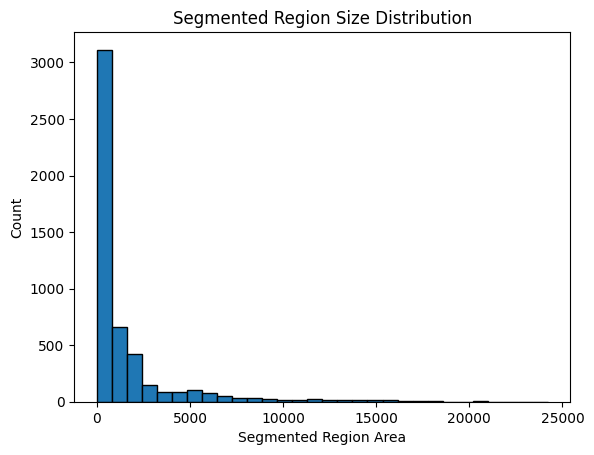

In [ ]:
import matplotlib.pyplot as plt

# Compute the area of each segmented region
yolo_df['segment_area'] = yolo_df['Segmentation'].apply(lambda seg: len(seg))

# Plot histogram of segmented region sizes
plt.hist(yolo_df['segment_area'].dropna(), bins=30, edgecolor='k')
plt.title('Segmented Region Size Distribution')
plt.xlabel('Segmented Region Area')
plt.ylabel('Count')
plt.show()


### Segmented Region Center Positions

This cell focuses on the spatial distribution of segmented region centers within the processed YOLOv8 segmentation data. A custom function, _'calculate_center'_, is defined to compute the center coordinates (X, Y) of each segmented region. The calculated centers are stored in a new column named _'segment_centers'_ in the DataFrame.

The subsequent analysis includes:

* __Extraction of Coordinates:__ The X and Y coordinates are extracted from the 'segment_centers' column.

* __Scatter Plot:__ A scatter plot is generated using Matplotlib to visualize the distribution of segment centers. Each point on the plot represents the center position of a segmented region, providing a spatial overview of the distribution. The transparency (alpha) parameter is utilized to handle overlapping points and enhance visibility.

This visualization is valuable for understanding the spatial arrangement of segmented regions, aiding in identifying patterns or trends in the dataset. Researchers or practitioners can leverage this information for further insights into the spatial characteristics of ship segments in the images.

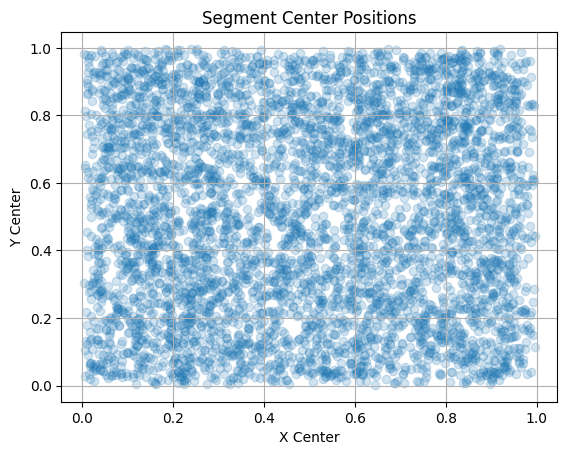

In [ ]:
# Function to calculate the center of a segmented region
def calculate_center(segment):
    ys, xs = zip(*segment)
    return np.mean(xs), np.mean(ys)

# Calculate centers
yolo_df['segment_centers'] = yolo_df['Segmentation'].apply(calculate_center)

# Extract x and y coordinates
x_centers, y_centers = zip(*yolo_df['segment_centers'].dropna())

# Scatter plot of segment centers
plt.scatter(x_centers, y_centers, alpha=0.2)
plt.title('Segment Center Positions')
plt.xlabel('X Center')
plt.ylabel('Y Center')
plt.grid(True)
plt.show()


### Visualization of Segmentation Masks on Images

This section of the code focuses on visualizing the segmentation masks on a subset of images. The script utilizes the 'matplotlib' library to create a plot showing the original image alongside the segmentation masks.

* __Image Directory:__
  * The variable __'image_dir'__ is defined as the directory containing the images corresponding to the 'ImageId' values in the DataFrame.
* __Visualization Loop:__
  * A loop iterates through a specified number of unique 'ImageId' values from the DataFrame.
  * For each image, the script opens the image file using the Pillow library (__'Image.open'__) and extracts its shape.
  * A matplotlib figure and axis are created for plotting the image and segmentation masks.
  * Segmentation masks are retrieved from the DataFrame for the current image and plotted on the axis using red lines.
* __Visualization Output:__
  * The resulting plot shows the original image overlaid with segmentation masks, providing a visual representation of the annotated regions.

This visualization is crucial for inspecting the quality of segmentation annotations and gaining insights into how well the model has learned to identify ship regions in the images.

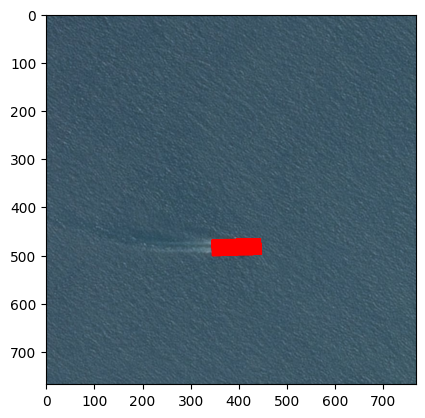

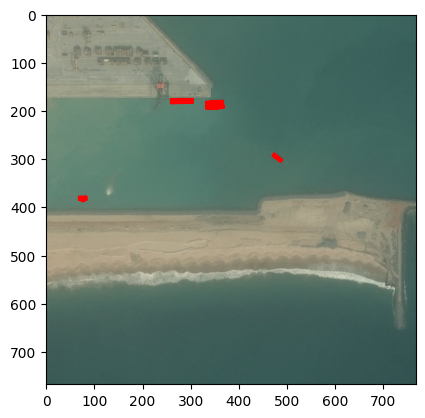

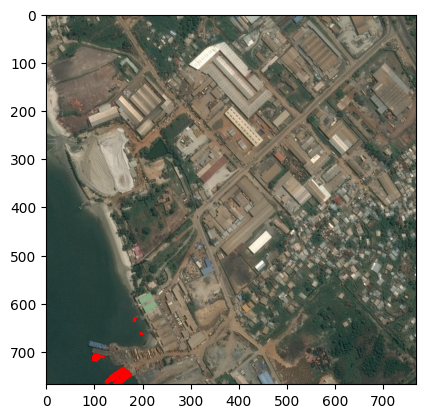

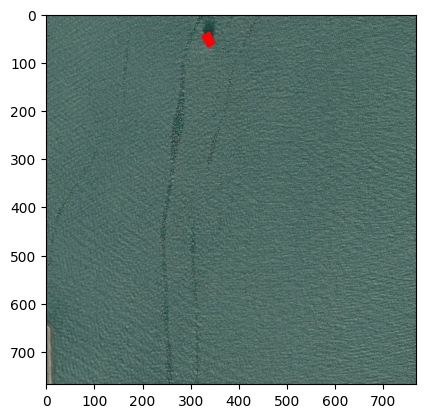

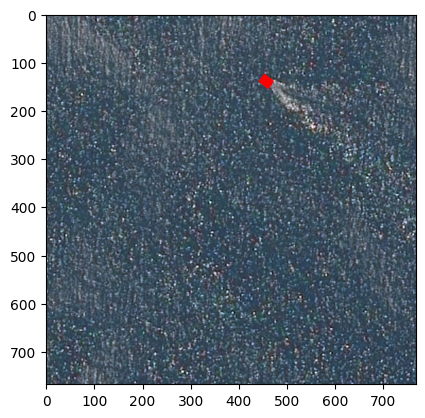

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Assuming yolo_df is your DataFrame with ['ImageId', 'Segmentation'] columns
# and it's already defined and filled with your data

# Directory containing the images
image_dir = '/content/drive/MyDrive/dataa/train_v2/'

# Plot the first few images with segmentation masks
num_images_to_plot = 5
unique_image_ids = yolo_df['ImageId'].unique()

for image_id in unique_image_ids[:num_images_to_plot]:
    image_path = image_dir + image_id
    image = Image.open(image_path)
    image_shape = image.size

    # Create a matplotlib figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Get all rows with the current image_id
    rows = yolo_df[yolo_df['ImageId'] == image_id]

    # Draw all segmentation masks for the current image
    for _, row in rows.iterrows():
        segmentation = row['Segmentation']
        # Plot each point in the segmentation mask
        x_points = [point[1] * image_shape[0] for point in segmentation]
        y_points = [point[0] * image_shape[1] for point in segmentation]
        ax.plot(x_points, y_points, color='red', linewidth=1)

    # Show the plot
    plt.show()

### Dataset Creation and Organization (Already Executed)

_Note:_ These cells are for informational purposes and were executed once to create the label files and the yaml fie. They are now readily available in the ‘data4’ directory for access and usage. There is no need to re-run this extraction process, and you can proceed to the subsequent cells.

The first code segment defines a function, save_dataset, which facilitates the organization and creation of a custom dataset structure suitable for training a YOLOv8 model. The script uses the 'os' and 'PIL' (Python Imaging Library) modules to manipulate files and images.

* __Function Description:__
  * The save_dataset function takes a dataset, dataset type, and base path as input parameters.
  * It creates directories for images and labels within the specified base path, and then iterates through the dataset to copy images and generate label files.
  * Label files are created in YOLOv8 format, and for each segmented region in the dataset, the function writes the corresponding coordinates to the label file.
* __Dataset Creation:__
  * Three datasets ('train', 'valid', and 'test') are created using this function, and each dataset has its own image and label directories.
* __YAML Configuration:__
  * The script generates a YAML configuration file (dataset.yaml) that specifies the dataset structure, including paths to the train, validation, and test images.

These codes prepare the dataset in a YOLOv8-compatible structure, making it ready for training a YOLOv8 model on ship segmentation tasks.

In [ ]:
import os
from PIL import Image

def save_dataset(dataset, dataset_type, base_path='/content/drive/MyDrive/data4', original_dir='/content/drive/MyDrive/dataa/train_v2'):
    images_path = os.path.join(base_path, dataset_type, 'images')
    labels_path = os.path.join(base_path, dataset_type, 'labels')

    os.makedirs(images_path, exist_ok=True)
    os.makedirs(labels_path, exist_ok=True)

    for index, row in dataset.iterrows():
        # Copy the image
        original_image_path = os.path.join(original_dir, f'{row["ImageId"]}')
        new_image_path = os.path.join(images_path, f'{row["ImageId"]}')
        Image.open(original_image_path).save(new_image_path)

        # Create and save the label file
        label_file = os.path.join(labels_path, f'{os.path.splitext(row["ImageId"])[0]}.txt')
        with open(label_file, 'w') as file:
            if isinstance(row['Segmentation'], list):
                file.write('0 ')
                for segment in row['Segmentation']:
                    if isinstance(segment, tuple):
                        # If the segment is a tuple, write it directly
                        file.write(' '.join(map(str, segment)) + ' ')

            else:
                # Handle other formats (like numpy arrays) here
                pass

In [ ]:
'''

save_dataset(train_df, 'train')
save_dataset(val_df, 'valid')
save_dataset(test_df, 'test')

'''

"\n\nsave_dataset(train_df, 'train')\nsave_dataset(val_df, 'valid')\nsave_dataset(test_df, 'test')\n\n"

In [ ]:
'''

yaml_content = f"""
path: /content/drive/MyDrive/data4  # dataset root dir
train: train/images  # train images relative path
val: valid/images  # val images relative path
test: test/images  # test images relative path

# Classes
nc: 1  # number of classes
names: ['Ship']  # class names
"""

with open('/content/drive/MyDrive/data4/dataset.yaml', 'w') as file:
    file.write(yaml_content)

'''

'\n\nyaml_content = f"""\npath: /content/drive/MyDrive/data4  # dataset root dir\ntrain: train/images  # train images relative path\nval: valid/images  # val images relative path\ntest: test/images  # test images relative path\n\n# Classes\nnc: 1  # number of classes\nnames: [\'Ship\']  # class names\n"""\n\nwith open(\'/content/drive/MyDrive/data4/dataset.yaml\', \'w\') as file:\n    file.write(yaml_content)\n\n'

## 2. Object Detection Model Training

In this section, we delve into the training phase of our YOLOv8 model, a pivotal step in developing a robust object detection solution. Leveraging the well-prepared dataset from the previous section, our focus shifts to the training pipeline, where the model learns to accurately detect and classify objects within images.

### YOLOv8 Model Training

This code segment demonstrates the training of a YOLOv8 model using the 'ultralytics' library. The script loads a pretrained YOLOv8 model and then trains it using a custom dataset configuration.

* __Model Loading:__
  * The script starts by loading a YOLOv8 model from a pretrained weight file using the 'YOLO' class from the 'ultralytics' library.
* __Model Training:__
  * The loaded model is then trained using the __'train'__ method, which takes as input the path to the dataset configuration file (__'dataset.yaml'__), the number of training epochs (in this case, 50), and the desired image size (__'imgsz'__).
* __Training Results:__
  * The training results are stored in the __'results'__ variable, providing valuable information such as loss values, metrics, and other statistics.

This script serves as a foundational step in training a YOLOv8 model for ship segmentation, leveraging a custom dataset structure prepared earlier in the script. Researchers or practitioners can adjust the training parameters and incorporate additional configurations based on the specific requirements of their segmentation task.

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n-seg.pt')  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data='/content/drive/MyDrive/data4/dataset.yaml', epochs=50, imgsz=768)

100%|██████████| 6.73M/6.73M [00:00<00:00, 160MB/s]


Ultralytics YOLOv8.0.217 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/data4/dataset.yaml, epochs=50, patience=50, batch=16, imgsz=768, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscrip

100%|██████████| 755k/755k [00:00<00:00, 35.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 181MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/.shortcut-targets-by-id/1hYe7QkSBkYvLi3skmBat5-dw1-QkhA_d/data4/train/labels... 2049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2049/2049 [17:05<00:00,  2.00it/s]


train: New cache created: /content/drive/.shortcut-targets-by-id/1hYe7QkSBkYvLi3skmBat5-dw1-QkhA_d/data4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/.shortcut-targets-by-id/1hYe7QkSBkYvLi3skmBat5-dw1-QkhA_d/data4/valid/labels... 607 images, 0 backgrounds, 1 corrupt: 100%|██████████| 607/607 [04:57<00:00,  2.04it/s]

val: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1hYe7QkSBkYvLi3skmBat5-dw1-QkhA_d/data4/valid/images/05681e655.jpg: ignoring corrupt image/label: labels require 5 columns, 3 columns detected


val: New cache created: /content/drive/.shortcut-targets-by-id/1hYe7QkSBkYvLi3skmBat5-dw1-QkhA_d/data4/valid/labels.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 768 train, 768 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.99G      3.622      5.434      9.552      2.723          1        768: 100%|██████████| 129/129 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.40it/s]


                   all        606        606   0.000105     0.0314   5.59e-05   1.91e-05          0          0          0          0

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.03G      3.818      5.224      5.981      2.618          3        768: 100%|██████████| 129/129 [01:23<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


                   all        606        606    0.00021     0.0033   0.000112    3.5e-05          0          0          0          0

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50         4G      3.805      5.127      5.073      2.489          2        768: 100%|██████████| 129/129 [01:22<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:14<00:00,  1.29it/s]


                   all        606        606   9.59e-05     0.0215   4.98e-05   1.46e-05          0          0          0          0

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50         4G      3.695      5.088      4.992      2.534          2        768: 100%|██████████| 129/129 [01:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.90it/s]

                   all        606        606    0.00037     0.0033    0.00019   2.83e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.98G       3.62      5.132      5.025      2.543          1        768: 100%|██████████| 129/129 [01:23<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.70it/s]

                   all        606        606    0.00037     0.0033    0.00019   2.83e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.98G       3.69      5.091      4.994      2.625          1        768: 100%|██████████| 129/129 [01:21<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:13<00:00,  1.42it/s]

                   all        606        606   0.000739    0.00495   0.000374     0.0001          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.96G      3.649      5.057      4.959      2.624          0        768: 100%|██████████| 129/129 [01:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.86it/s]

                   all        606        606   0.000739    0.00495   0.000374     0.0001          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.98G       3.65      5.117      5.002      2.624          3        768: 100%|██████████| 129/129 [01:25<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]

                   all        606        606   0.000739    0.00495   0.000374     0.0001          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.02G      3.641      5.058      4.976      2.629          0        768: 100%|██████████| 129/129 [01:23<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.59it/s]

                   all        606        606   0.000739    0.00495   0.000374     0.0001          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.98G      3.611      5.066          5      2.583          3        768: 100%|██████████| 129/129 [01:20<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.55it/s]

                   all        606        606   0.000739    0.00495   0.000374     0.0001          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.96G      3.605      5.104      5.002      2.581          2        768: 100%|██████████| 129/129 [01:24<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]

                   all        606        606   0.000739    0.00495   0.000374     0.0001          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.97G      3.591      5.075      5.057       2.54          1        768: 100%|██████████| 129/129 [01:26<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]

                   all        606        606   0.000739    0.00495   0.000374     0.0001          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.97G      3.584      5.084      5.014      2.553          2        768: 100%|██████████| 129/129 [01:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]

                   all        606        606   0.000739    0.00495   0.000374     0.0001          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.97G      3.546      5.085      5.033      2.544          1        768: 100%|██████████| 129/129 [01:21<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.55it/s]

                   all        606        606   0.000739    0.00495   0.000374     0.0001          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.96G       3.56      5.093      5.074      2.532          2        768: 100%|██████████| 129/129 [01:23<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.70it/s]

                   all        606        606   0.000739    0.00495   0.000374     0.0001          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.97G      3.476      5.039      5.001      2.551          0        768: 100%|██████████| 129/129 [01:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.62it/s]

                   all        606        606   0.000575     0.0033   0.000292   4.36e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.98G      3.535      5.071      5.031      2.567          2        768: 100%|██████████| 129/129 [01:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.55it/s]

                   all        606        606   0.000575     0.0033   0.000292   4.36e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.94G      3.521       5.06      5.026      2.536          2        768: 100%|██████████| 129/129 [01:22<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.54it/s]

                   all        606        606   0.000575     0.0033   0.000292   4.36e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.96G       3.47      5.035       5.04      2.502          0        768: 100%|██████████| 129/129 [01:22<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.71it/s]

                   all        606        606   0.000575     0.0033   0.000292   4.36e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.97G      3.529      5.086      5.063      2.574          2        768: 100%|██████████| 129/129 [01:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]

                   all        606        606   0.000575     0.0033   0.000292   4.36e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.97G      3.489      5.066      5.063      2.515          2        768: 100%|██████████| 129/129 [01:27<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.69it/s]

                   all        606        606   0.000575     0.0033   0.000292   4.36e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.97G      3.431      5.068      5.037      2.549          3        768: 100%|██████████| 129/129 [01:24<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.52it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.96G      3.501      5.092      5.071      2.532          2        768: 100%|██████████| 129/129 [01:23<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50         4G      3.467      5.077      5.043      2.518          3        768: 100%|██████████| 129/129 [01:25<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.97G      3.441      5.065      5.023      2.538          1        768: 100%|██████████| 129/129 [01:25<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.87it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.97G      3.467      5.081      5.069      2.546          1        768: 100%|██████████| 129/129 [01:23<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.50it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.96G      3.466      5.055      5.054      2.506          4        768: 100%|██████████| 129/129 [01:23<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.72it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.97G      3.402      5.029      4.992        2.5          0        768: 100%|██████████| 129/129 [01:27<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.13it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.97G      3.456      5.057      5.097      2.489          2        768: 100%|██████████| 129/129 [01:26<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.77it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.97G      3.418      5.004      5.047      2.473          0        768: 100%|██████████| 129/129 [01:23<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.49it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.92G      3.429       5.06      5.061      2.501          2        768: 100%|██████████| 129/129 [01:24<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.72it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.97G      3.486       5.06      5.071       2.53          4        768: 100%|██████████| 129/129 [01:25<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.06it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.97G      3.451      5.028      5.049      2.521          0        768: 100%|██████████| 129/129 [01:25<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.98G      3.435      5.055      5.002      2.532          1        768: 100%|██████████| 129/129 [01:24<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.56it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.96G      3.428      5.092      5.077      2.482          4        768: 100%|██████████| 129/129 [01:21<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.98G      3.398      5.068      5.036      2.476          1        768: 100%|██████████| 129/129 [01:25<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.97G      3.501      5.066      5.042      2.541          2        768: 100%|██████████| 129/129 [01:25<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.97G      3.418      5.075      5.055       2.51          1        768: 100%|██████████| 129/129 [01:22<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.52it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.96G      3.415      5.037      5.043      2.509          1        768: 100%|██████████| 129/129 [01:21<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.98G      3.452       5.06      5.059      2.493          1        768: 100%|██████████| 129/129 [01:25<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.04it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.98G      3.459      5.095      5.185      2.568          1        768: 100%|██████████| 129/129 [01:22<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.12it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.97G      3.425      5.066      5.124      2.559          1        768: 100%|██████████| 129/129 [01:17<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.96G      3.463      5.083      5.149      2.592          1        768: 100%|██████████| 129/129 [01:16<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.71it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.98G      3.439      5.099      5.133      2.596          1        768: 100%|██████████| 129/129 [01:15<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.75it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.98G      3.394      5.075      5.101      2.568          1        768: 100%|██████████| 129/129 [01:15<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.57it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.98G      3.393      5.083      5.106      2.571          1        768: 100%|██████████| 129/129 [01:15<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:12<00:00,  1.58it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.96G      3.451       5.09      5.121       2.62          1        768: 100%|██████████| 129/129 [01:15<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.97G      3.379      5.035      5.101      2.554          1        768: 100%|██████████| 129/129 [01:16<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.23it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.97G      3.397      5.056      5.123      2.584          1        768: 100%|██████████| 129/129 [01:16<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.90it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.97G       3.43      5.096      5.143      2.612          1        768: 100%|██████████| 129/129 [01:15<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.60it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0



50 epochs completed in 1.332 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.217 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:14<00:00,  1.31it/s]

                   all        606        606    0.00224     0.0033    0.00132   0.000188          0          0          0          0


Speed: 0.6ms preprocess, 4.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/segment/train


## 3. Model Evaluation and Predictions

In this section, we shift our focus to assessing the performance of our trained model and making predictions on new data. After the diligent training process, it's crucial to rigorously evaluate how well the model generalizes to unseen scenarios.

### Display Confusion Matrix

The __'confusion_matrix.png'__ and __'confusion_matrix_normalized.png'__ files provide visual representations of the confusion matrix, which is a powerful tool for assessing the performance of a classification model. The confusion matrix shows the true positive, true negative, false positive, and false negative values for each class.

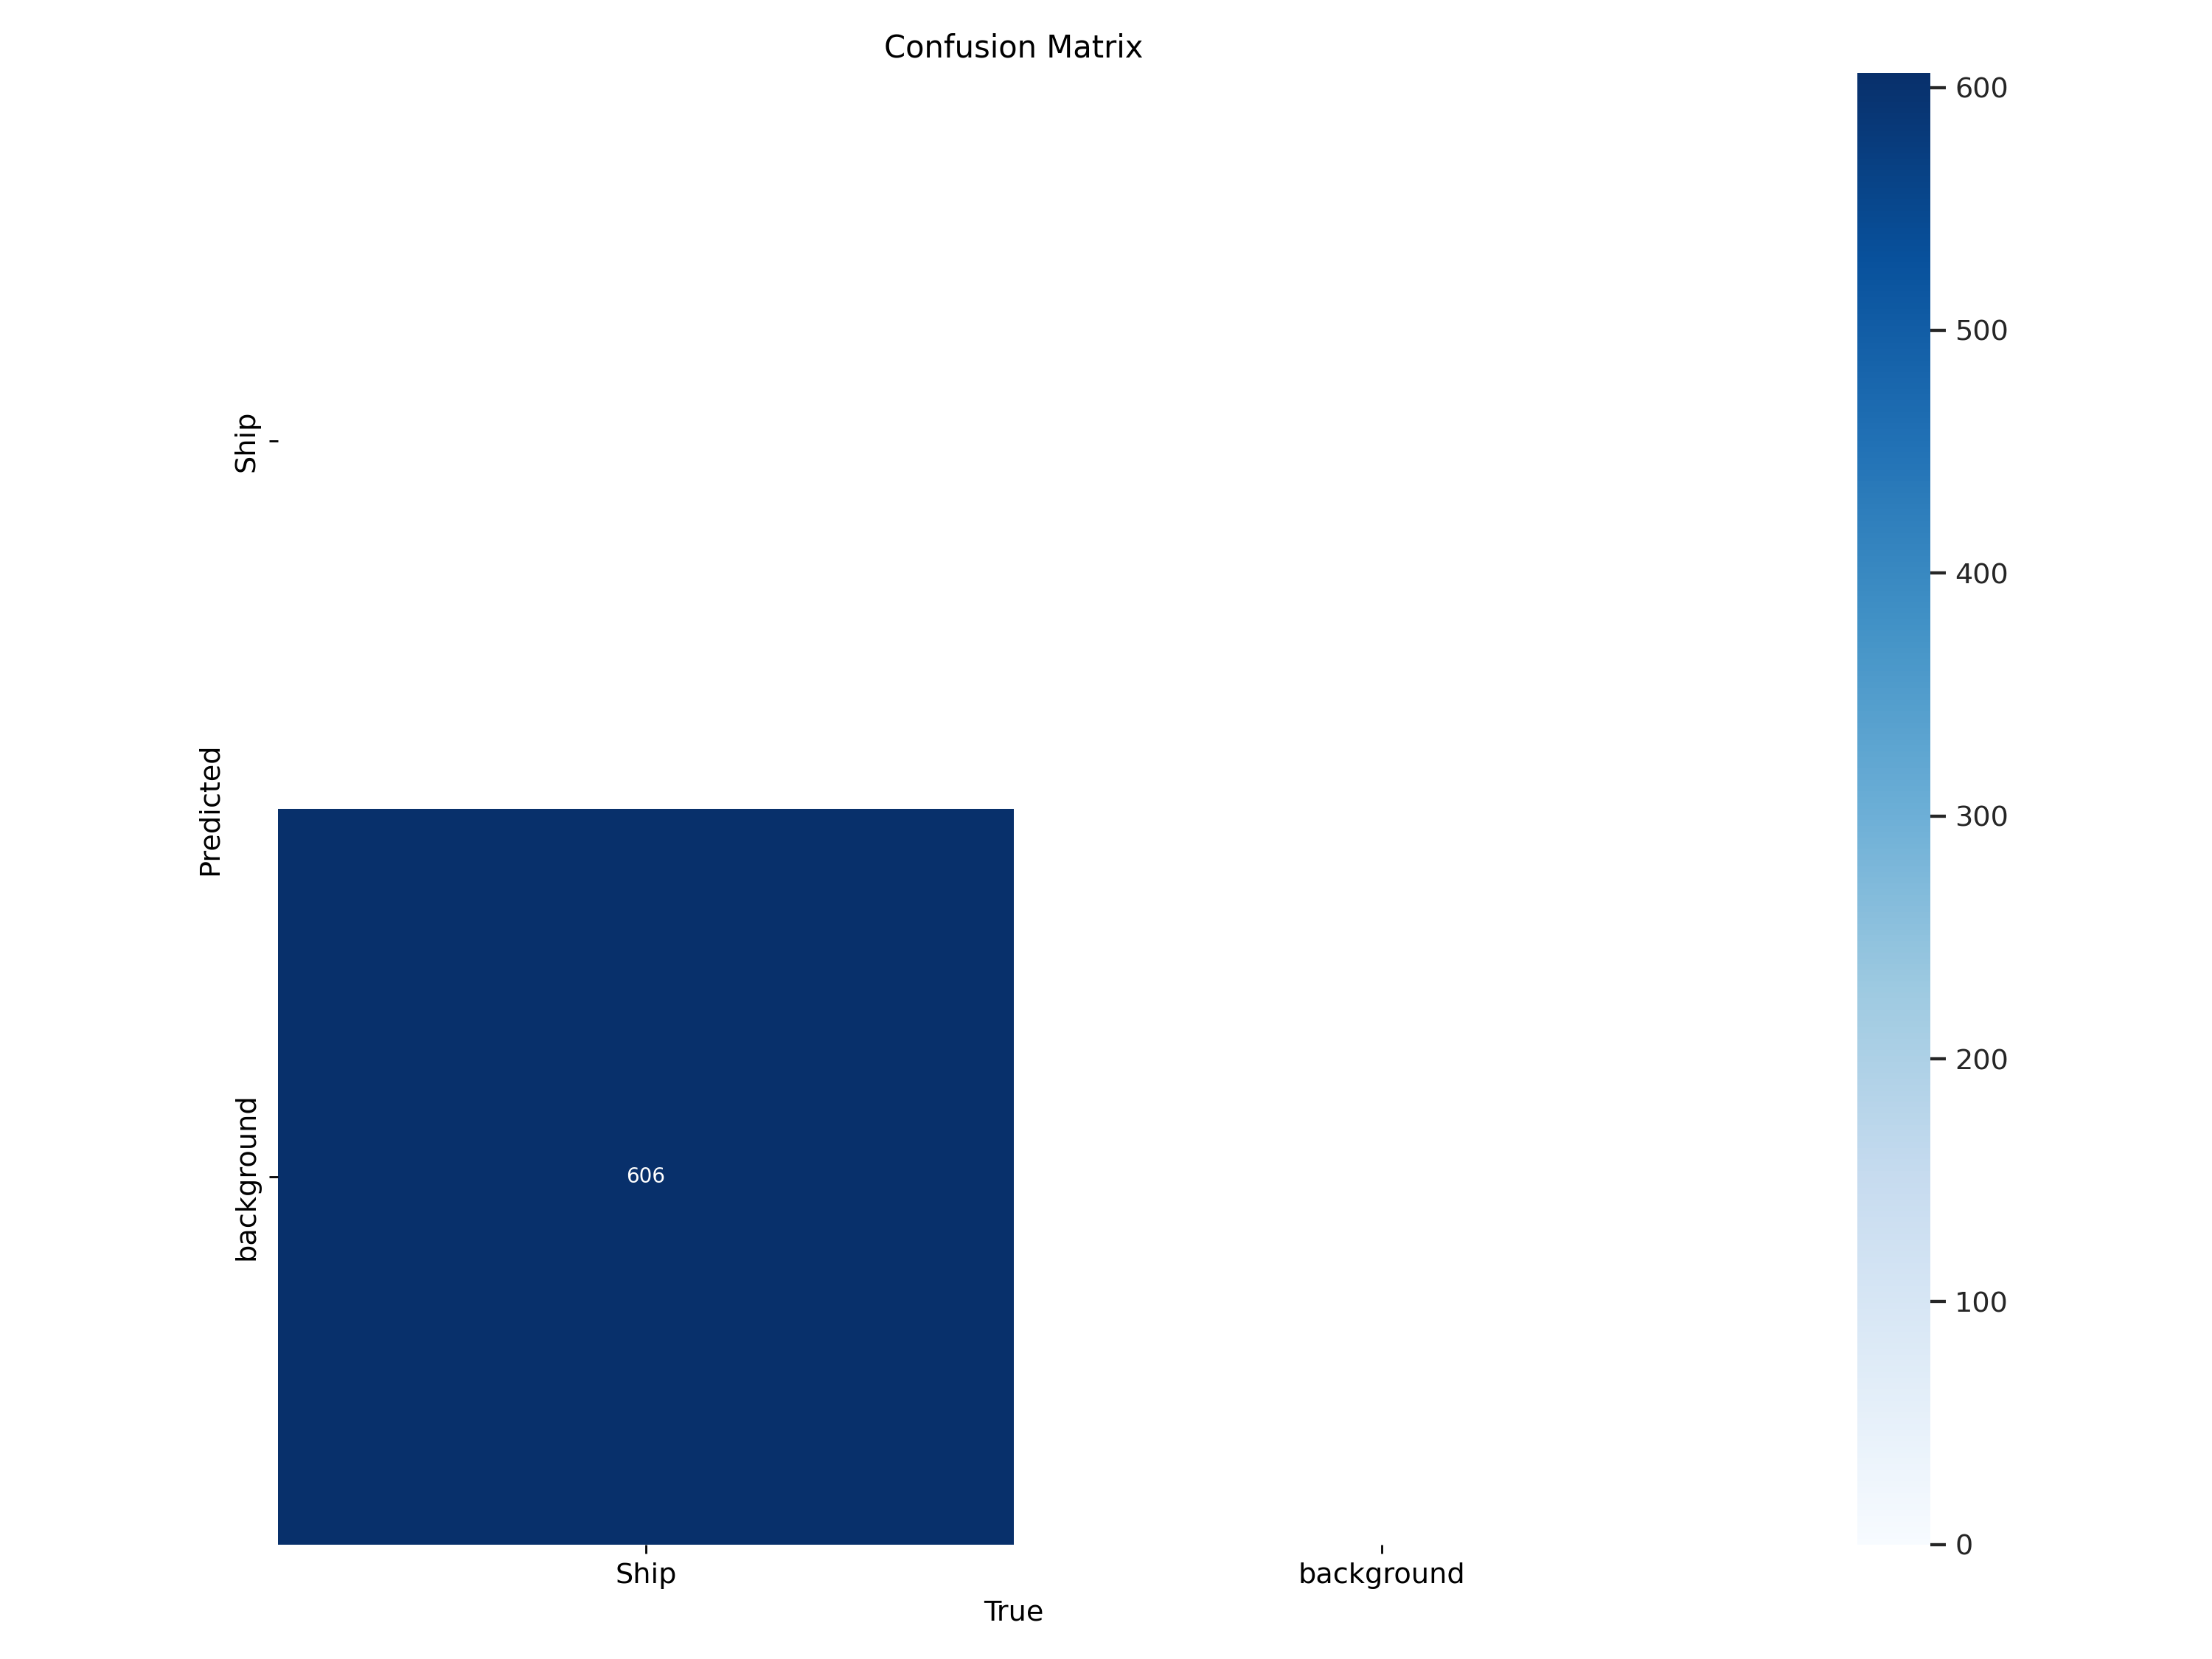

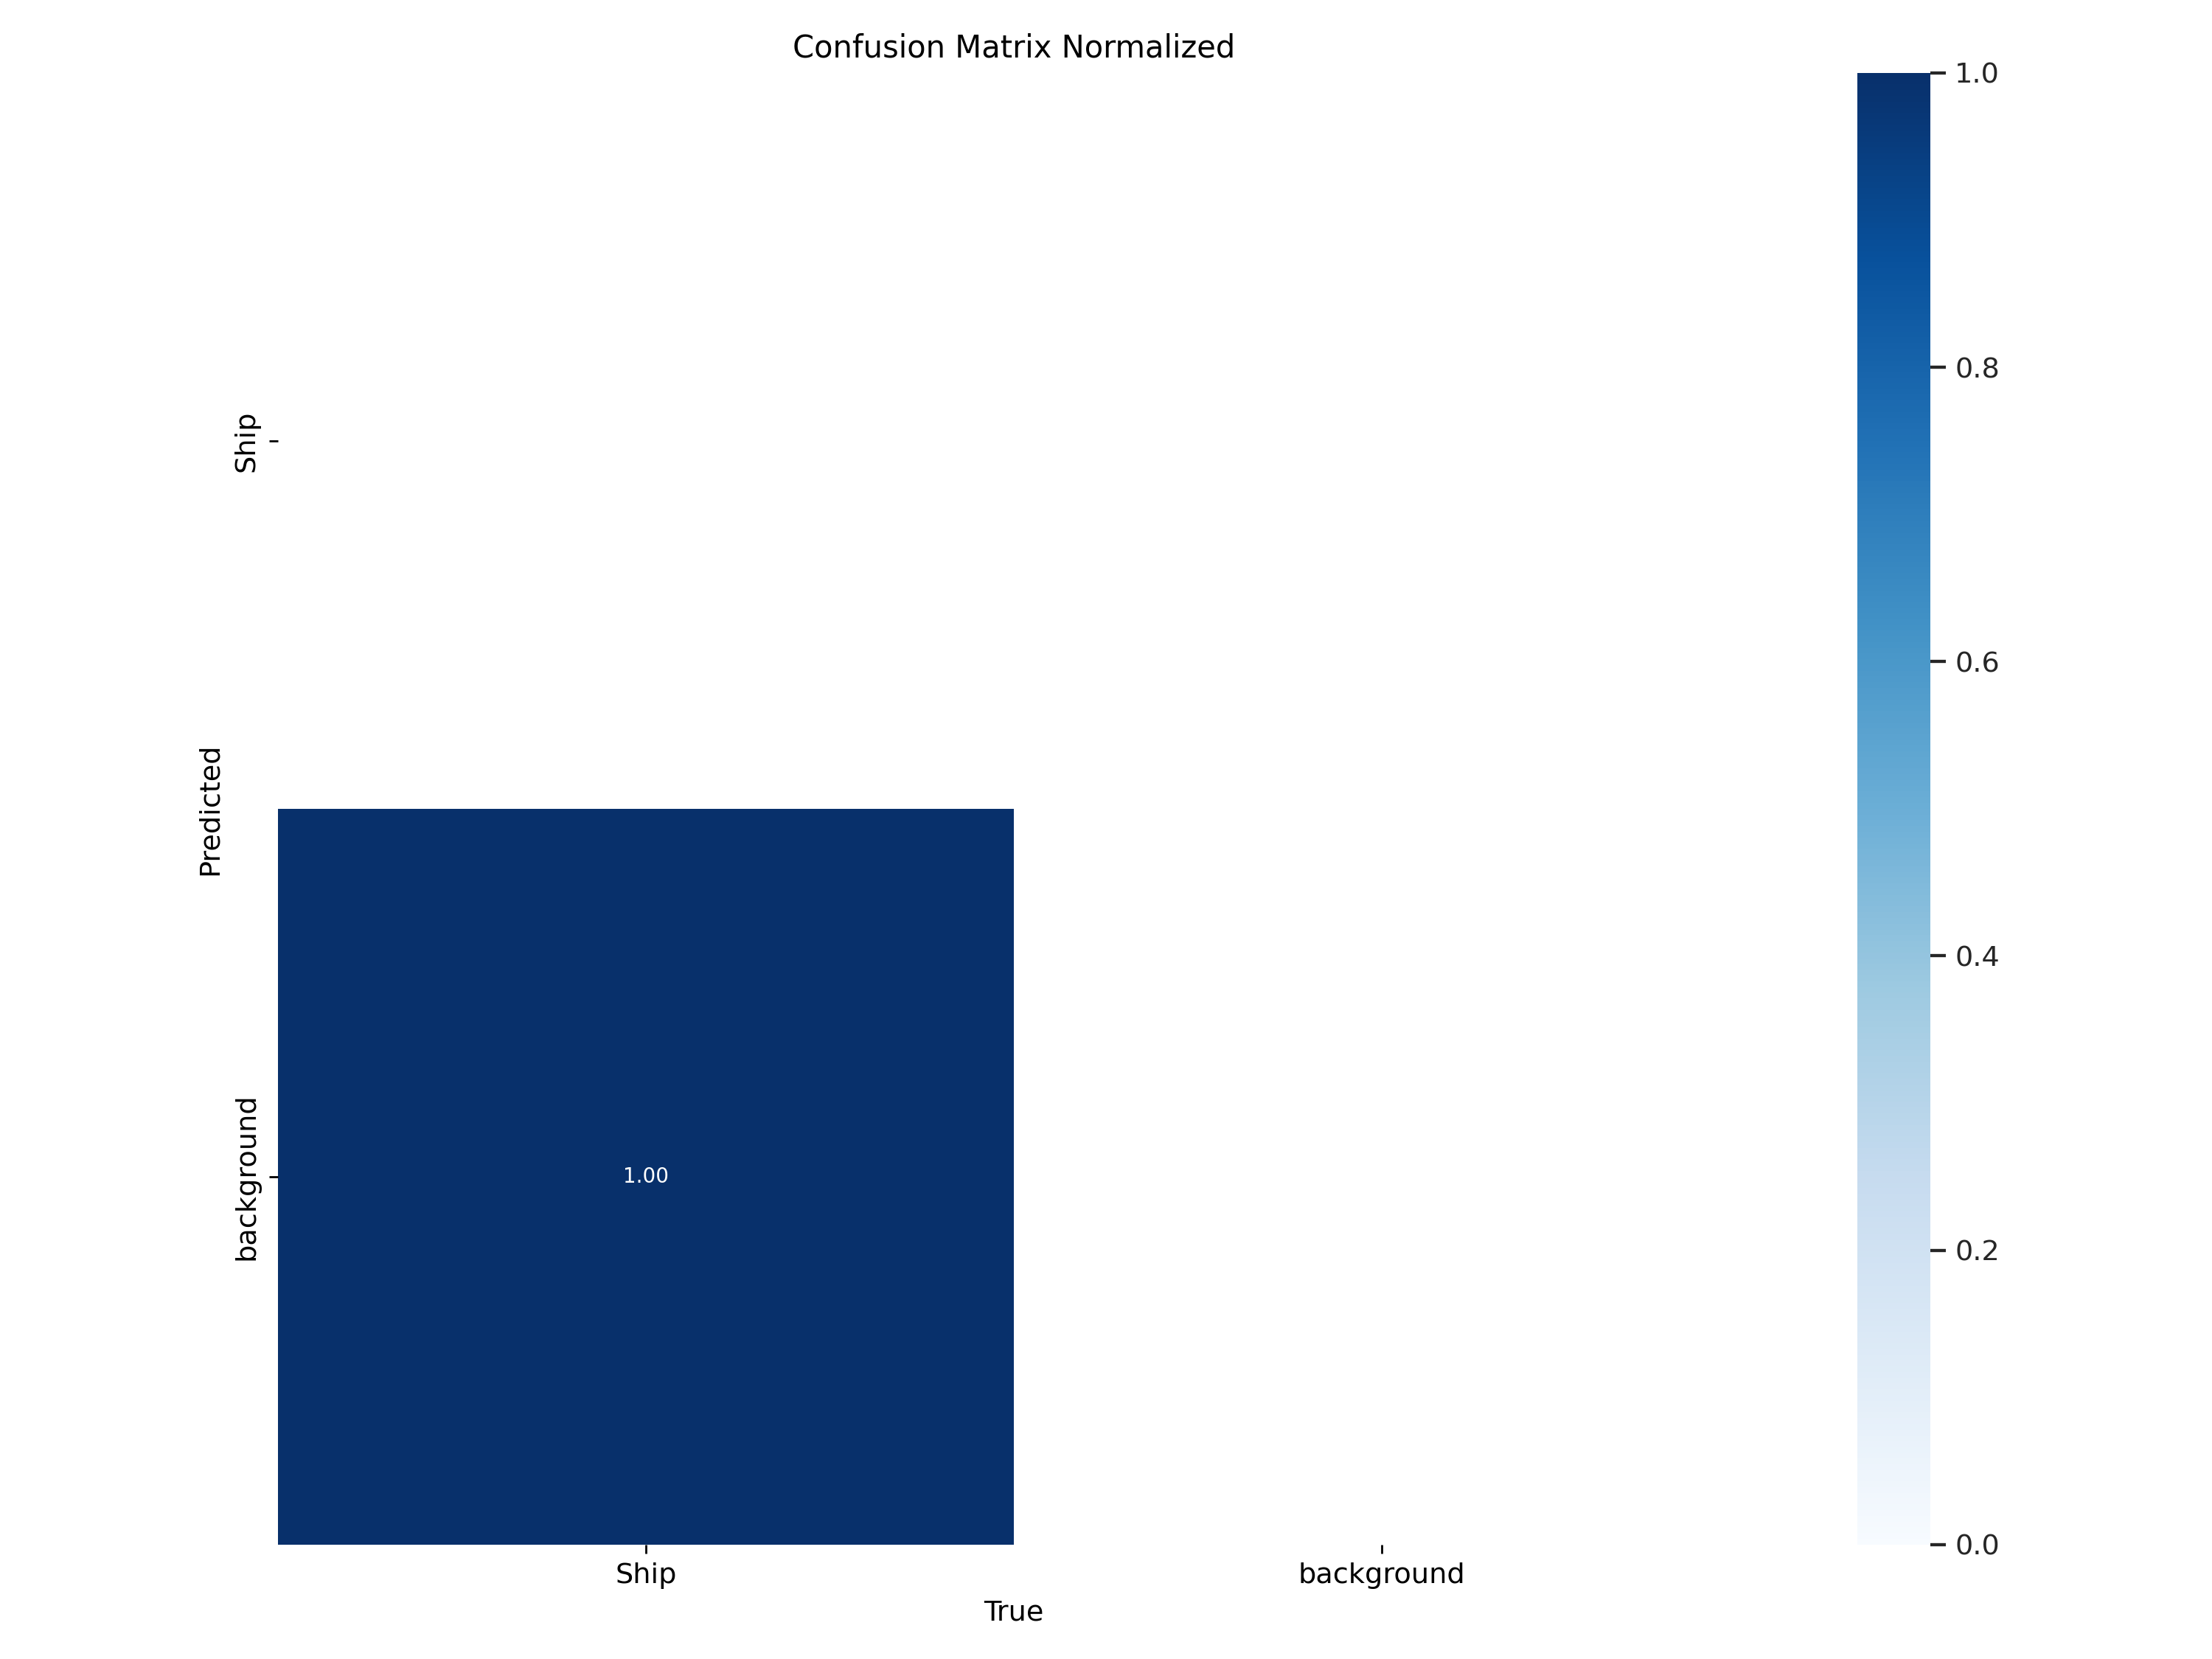

In [ ]:
from IPython.display import Image, display

# Display the confusion matrix and normalized confusion matrix images
display(Image(filename='/content/runs/segment/train/confusion_matrix.png',  width=600))
display(Image(filename='/content/runs/segment/train/confusion_matrix_normalized.png',  width=600))

### Load and Display Evaluation Results

The __'results.csv'__ file likely contains detailed metrics about the model's performance, such as precision, recall, and F1 score for each class. The Pandas DataFrame is employed to load and display the contents of the CSV file, offering a comprehensive view of the evaluation results.



In [ ]:
import pandas as pd

# Load the CSV file containing evaluation results
results_df = pd.read_csv('/content/runs/segment/train/results.csv')

# Display the Pandas DataFrame with evaluation results
results_df

epoch           train/box_loss           train/seg_loss  \
0                         1                   3.6218                   5.4340   
1                         2                   3.8184                   5.2236   
2                         3                   3.8046                   5.1266   
3                         4                   3.6954                   5.0876   
4                         5                   3.6204                   5.1320   
5                         6                   3.6900                   5.0913   
6                         7                   3.6494                   5.0568   
7                         8                   3.6498                   5.1168   
8                         9                   3.6413                   5.0578   
9                        10                   3.6112                   5.0663   
10                       11                   3.6053                   5.1039   
11                       12                   3.5905                   5.0746   
12                       13                   3.5842                   5.0842   
13                       14                   3.5457                   5.0847   
14                       15                   3.5596                   5.0930   
15                       16                   3.4761                   5.0389   
16                       17                   3.5353                   5.0714   
17                       18                   3.5215                   5.0604   
18                       19                   3.4701                   5.0346   
19                       20                   3.5290                   5.0863   
20                       21                   3.4892                   5.0662   
21                       22                   3.4307                   5.0683   
22                       23                   3.5010                   5.0917   
23                       24                   3.4674                   5.0767   
24                       25                   3.4412                   5.0652   
25                       26                   3.4666                   5.0806   
26                       27                   3.4665                   5.0547   
27                       28                   3.4022                   5.0293   
28                       29                   3.4564                   5.0569   
29                       30                   3.4181                   5.0035   
30                       31                   3.4291                   5.0596   
31                       32                   3.4857                   5.0598   
32                       33                   3.4507                   5.0278   
33                       34                   3.4354                   5.0548   
34                       35                   3.4276                   5.0917   
35                       36                   3.3984                   5.0682   
36                       37                   3.5005                   5.0657   
37                       38                   3.4181                   5.0752   
38                       39                   3.4153                   5.0373   
39                       40                   3.4518                   5.0601   
40                       41                   3.4593                   5.0948   
41                       42                   3.4253                   5.0656   
42                       43                   3.4633                   5.0831   
43                       44                   3.4390                   5.0994   
44                       45                   3.3939                   5.0752   
45                       46                   3.3931                   5.0828   
46                       47                   3.4515                   5.0900   
47                       48                   3.3788                   5.0348   
48                       49                   3.3971 

### Display Additional Results Visualization

The __'results.png'__ file may contain supplementary visualizations or metrics summarizing the model's performance on the validation set.

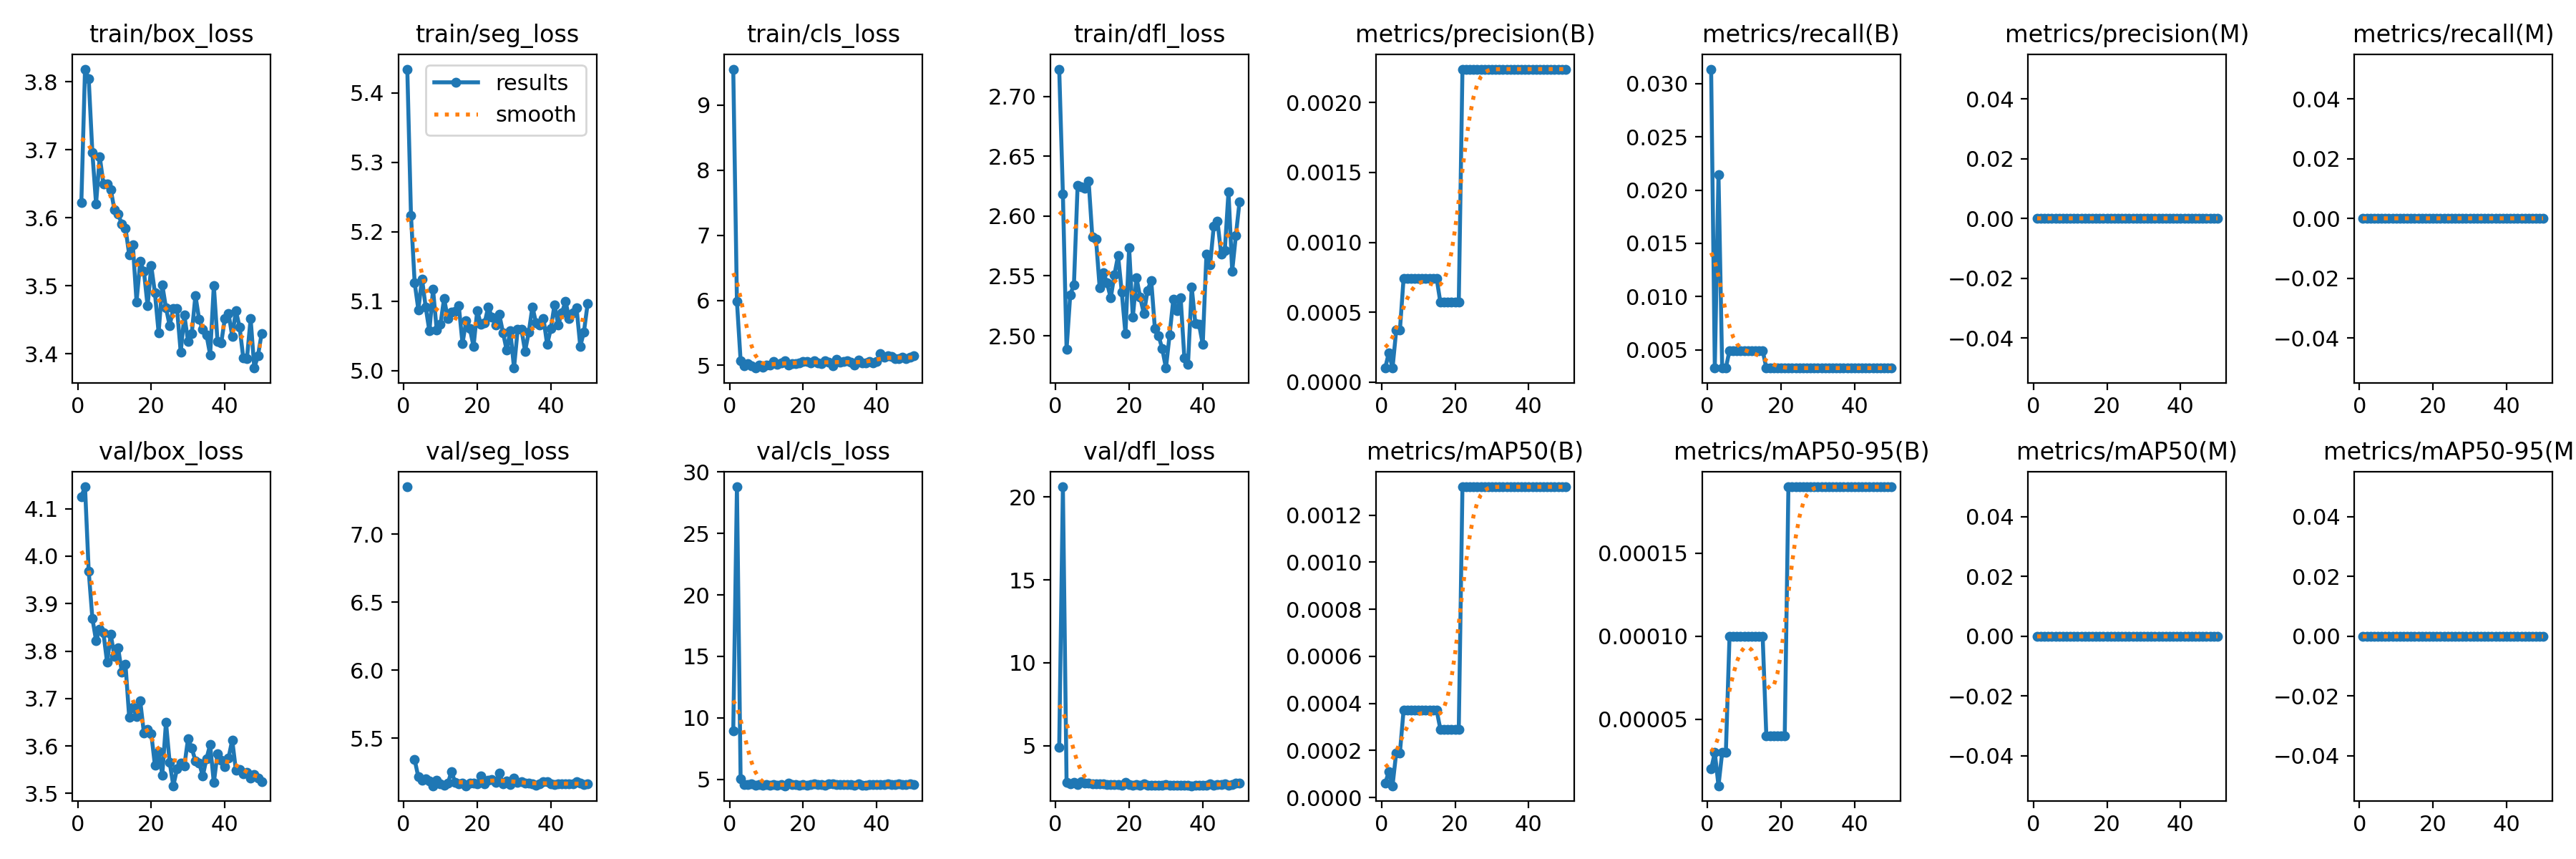

In [ ]:
from IPython.display import Image, display

# Display the additional results visualization image
display(Image(filename='/content/runs/segment/train/results.png'))

### Display Batch Images with Predictions

The __'train_batch0.jpg'__, __'val_batch0_labels.jpg'__, and __'val_batch0_pred.jpg'__ files likely show visualizations of the model's predictions on a specific batch of training or validation data. These images offer a side-by-side comparison of ground truth labels (__'val_batch0_labels.jpg'__) and predicted results (__'val_batch0_pred.jpg'__) for a particular batch.

train_batch0.jpg


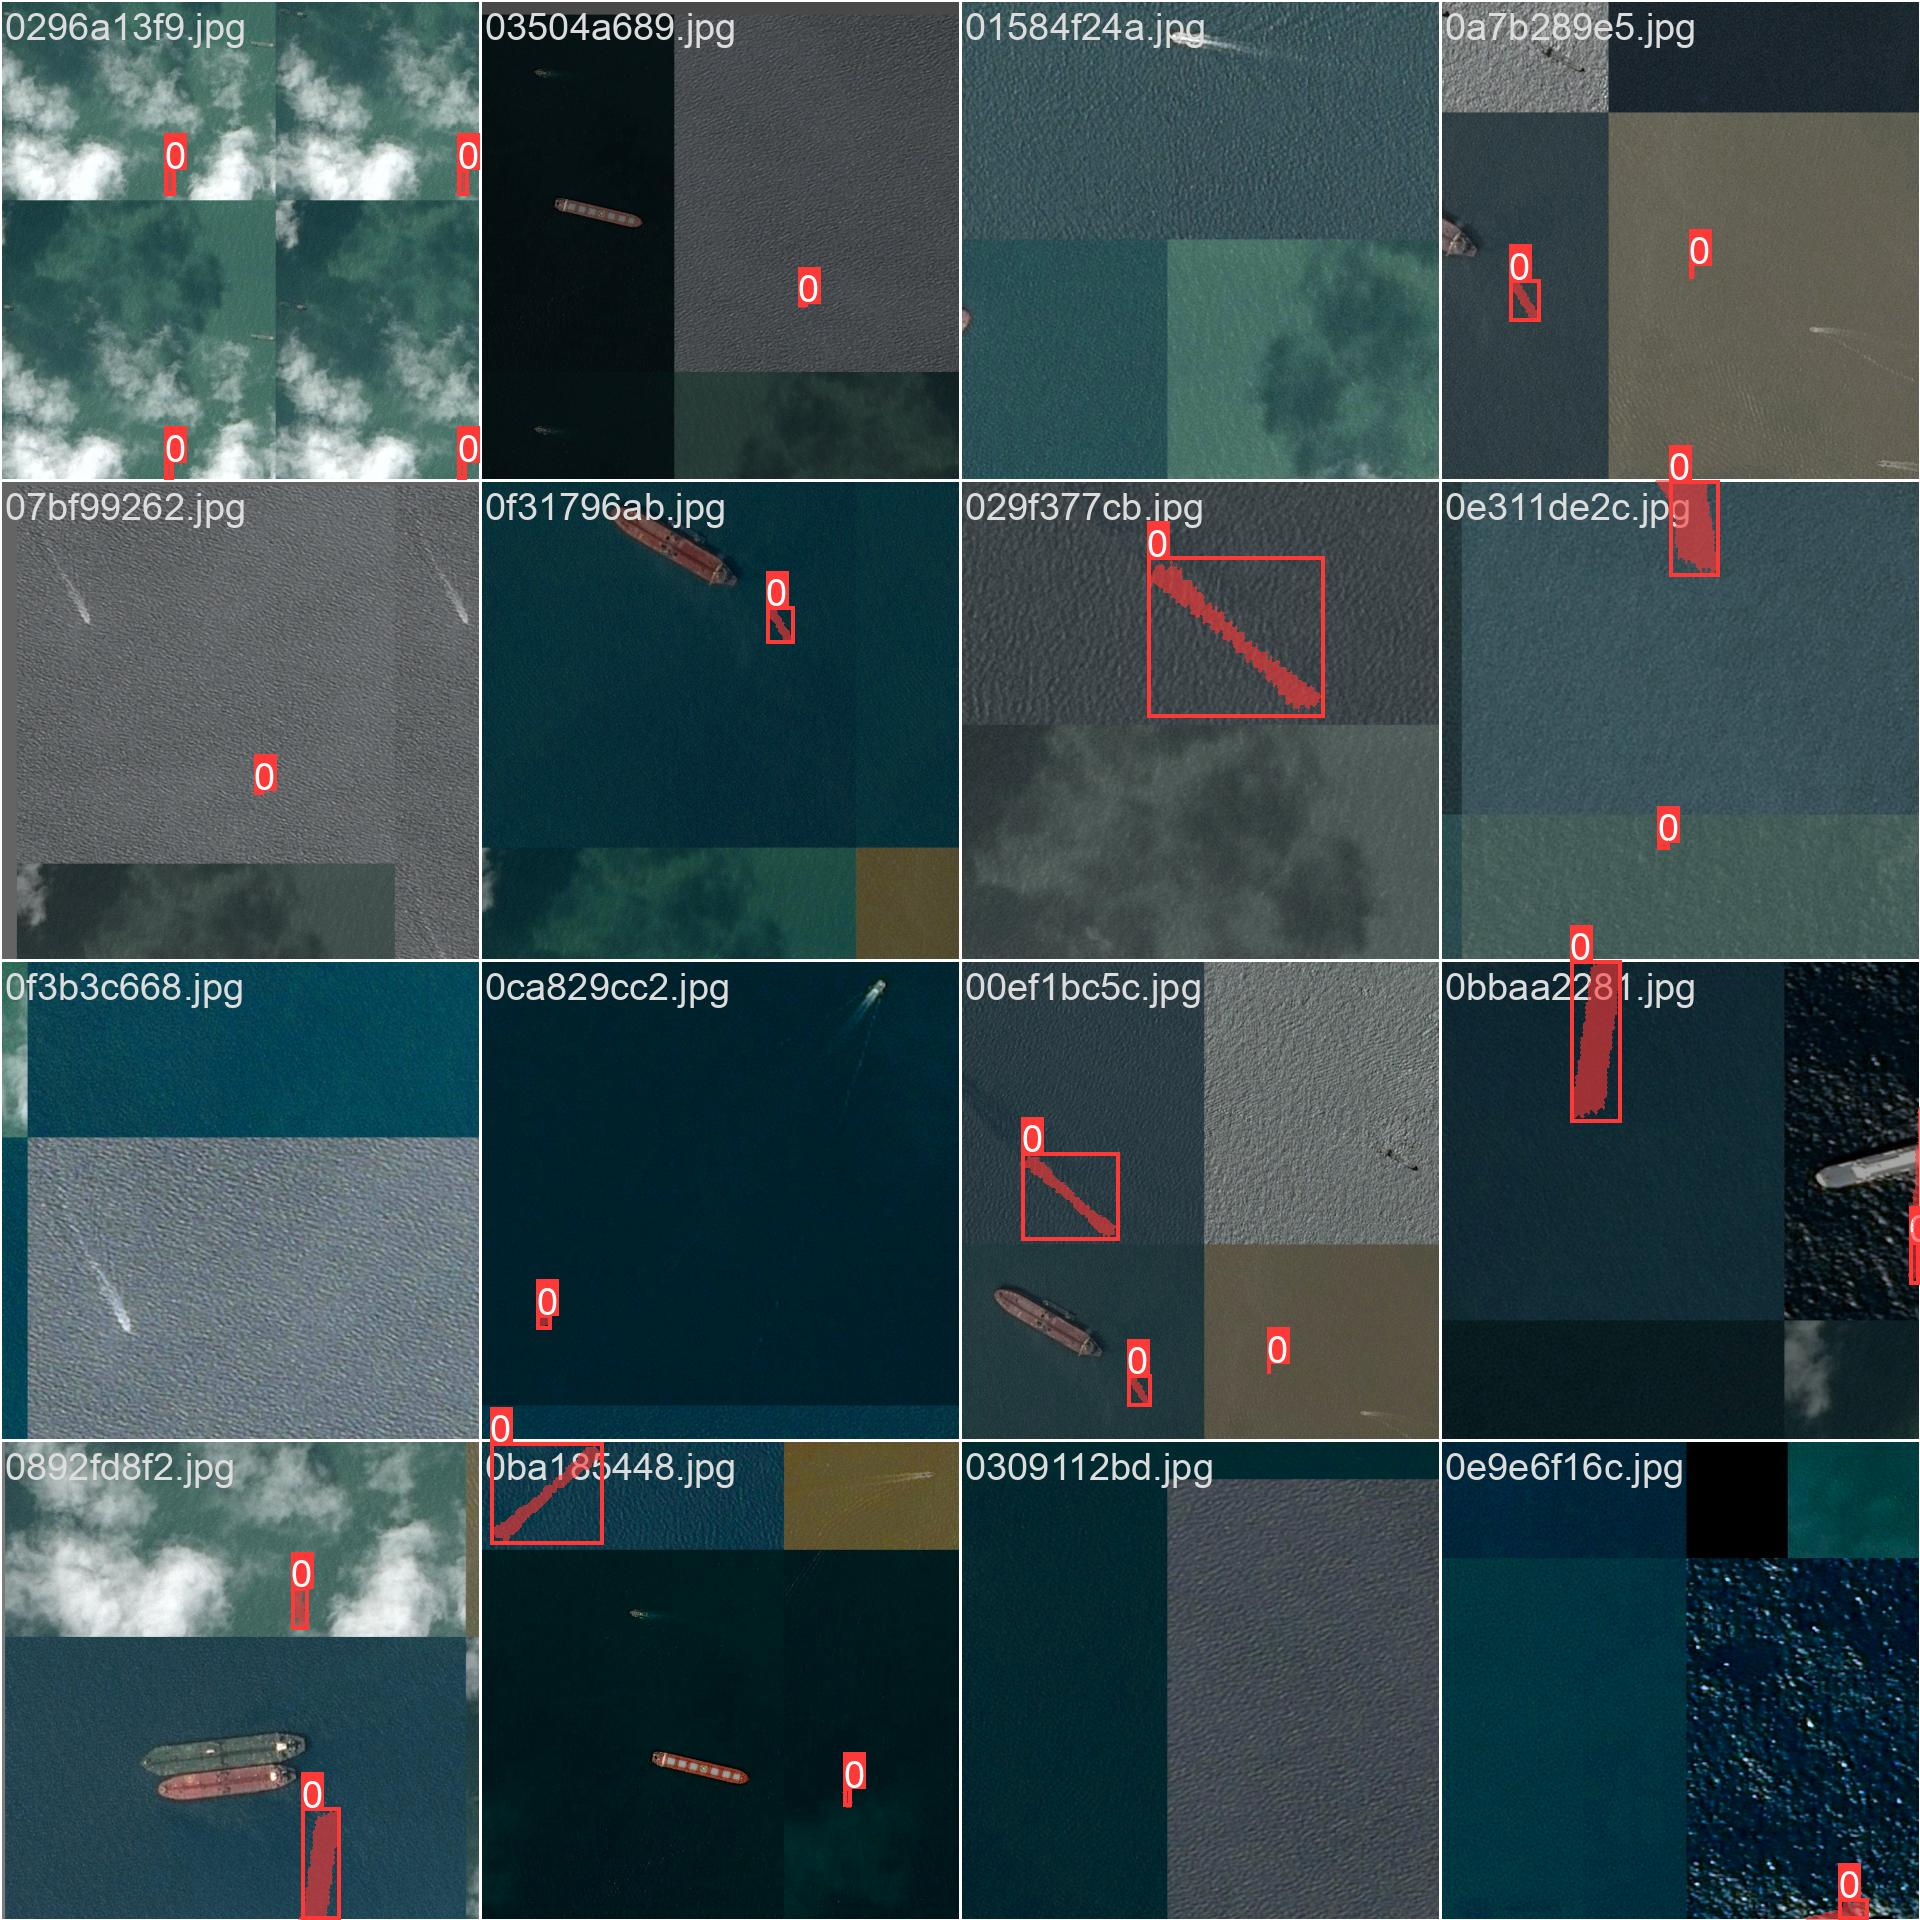

val_batch0_labels.jpg


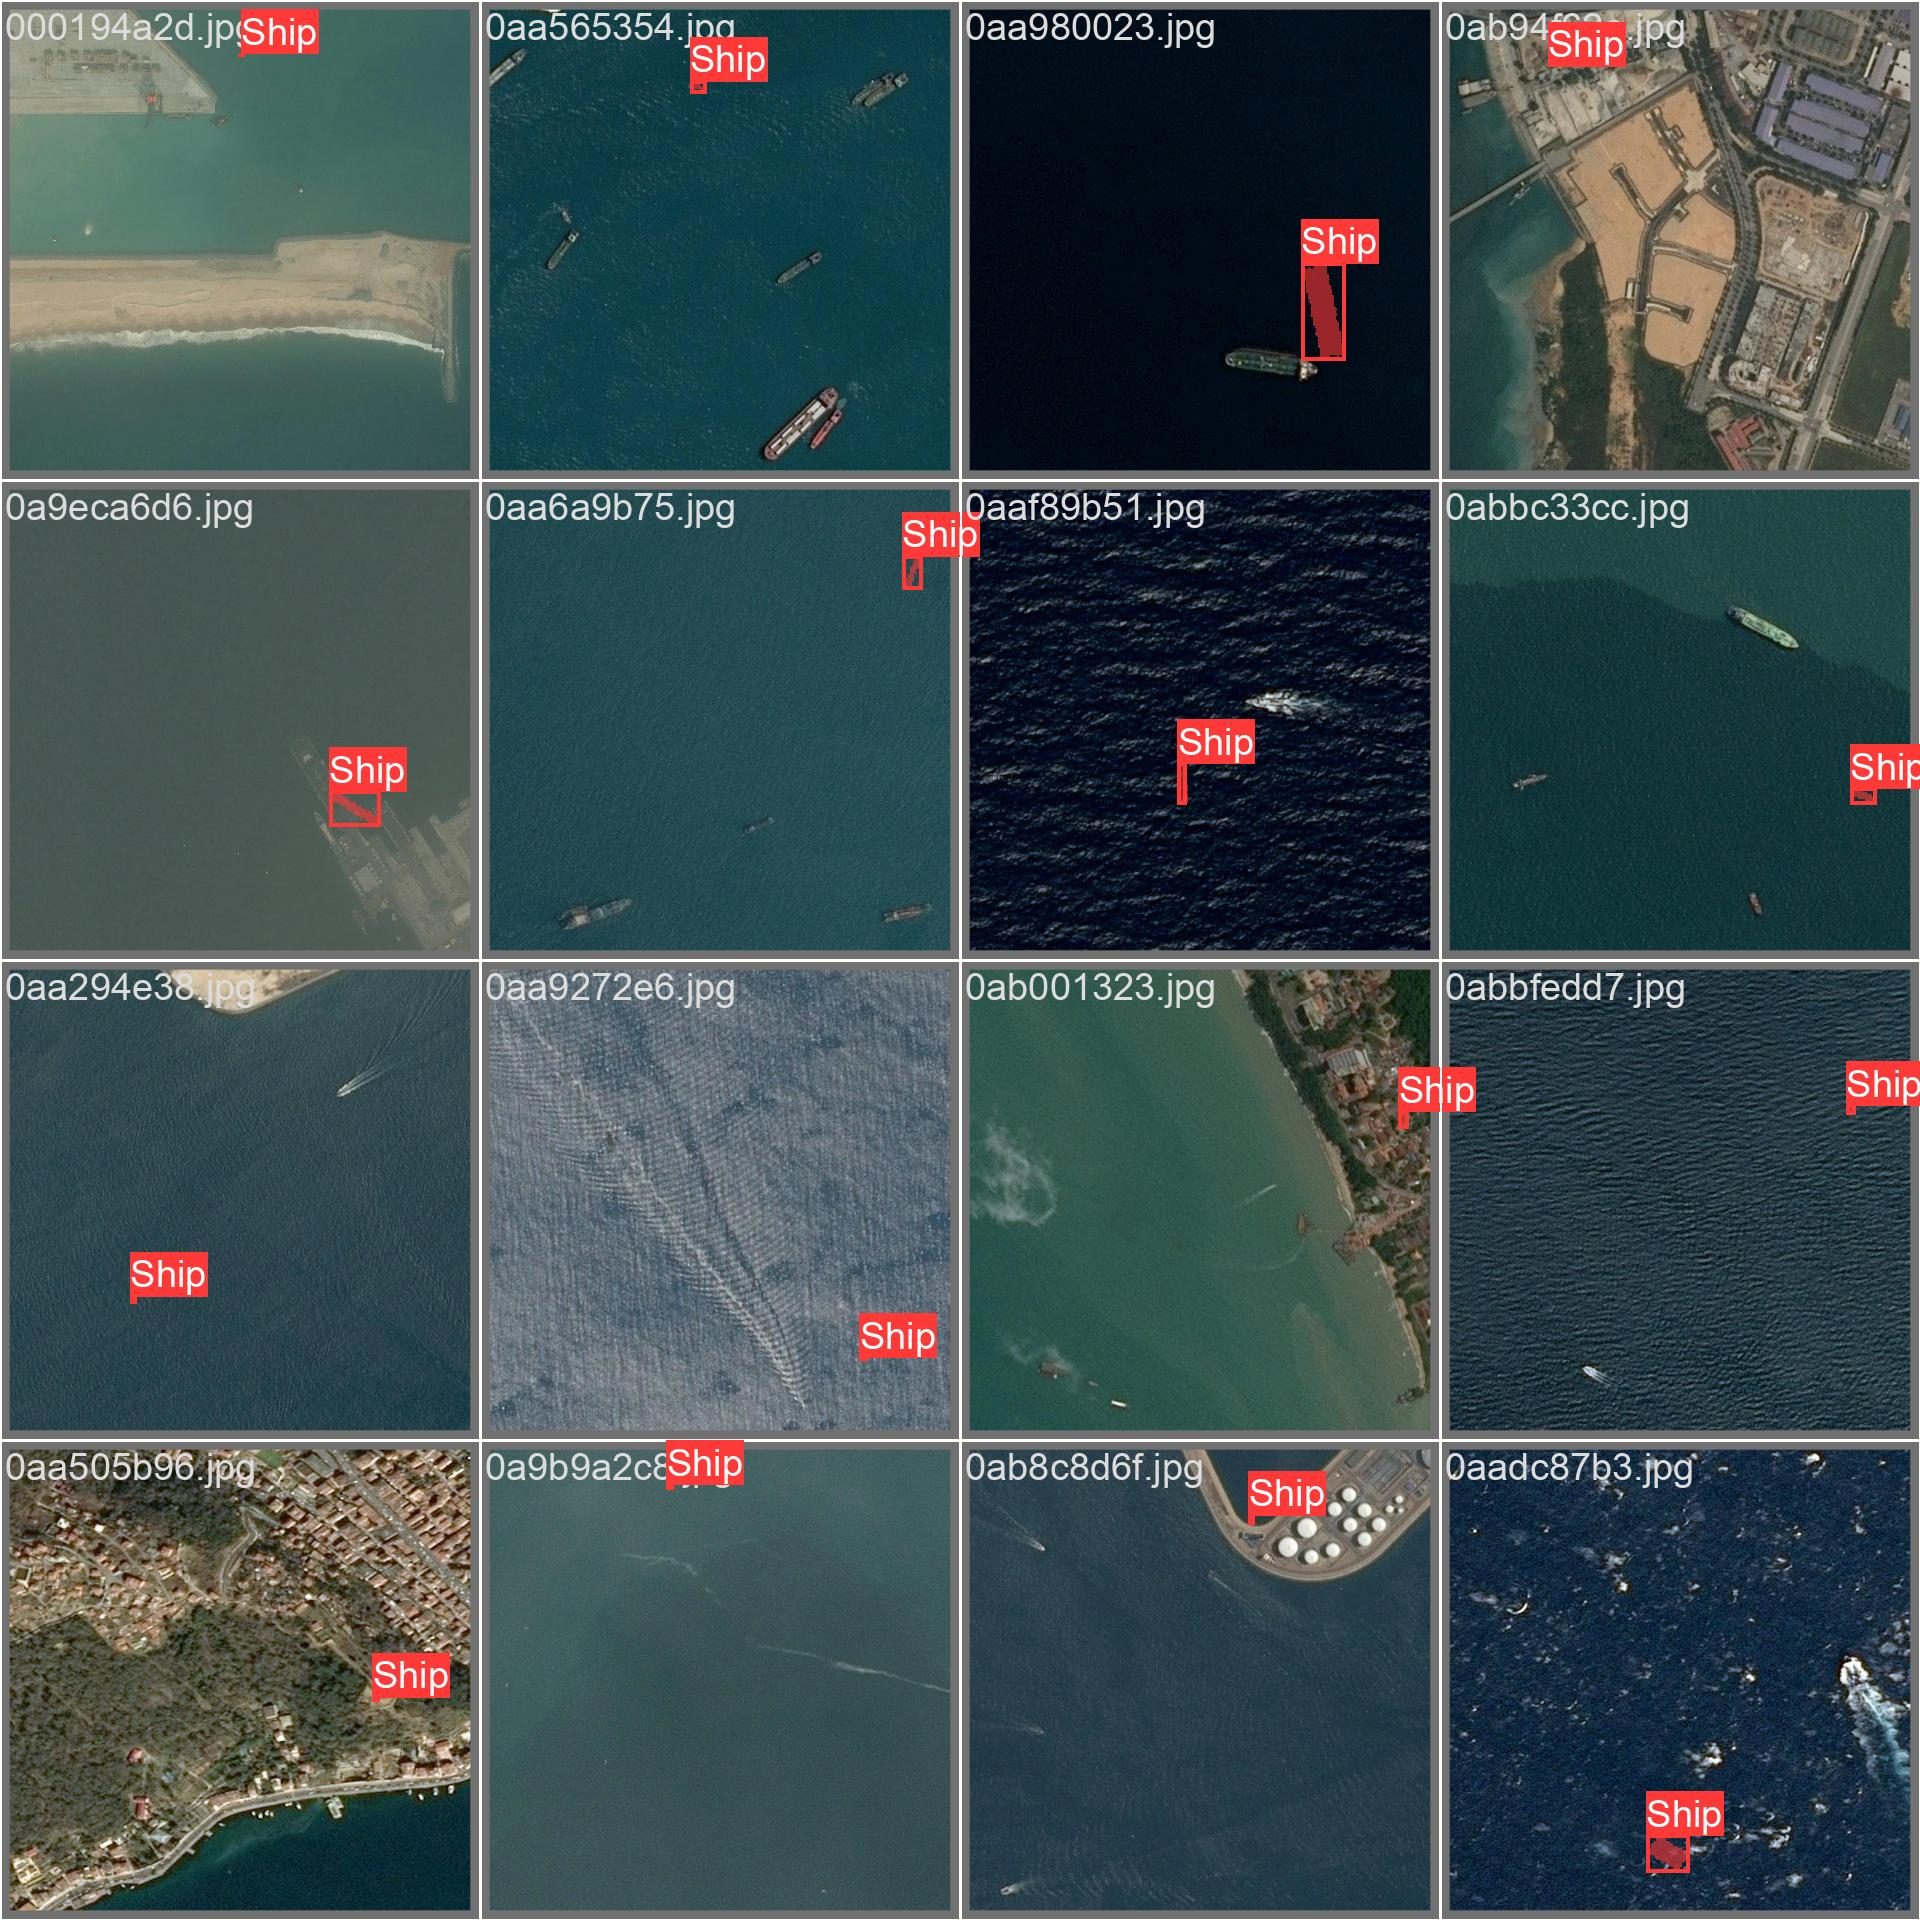

val_batch0_pred.jpg


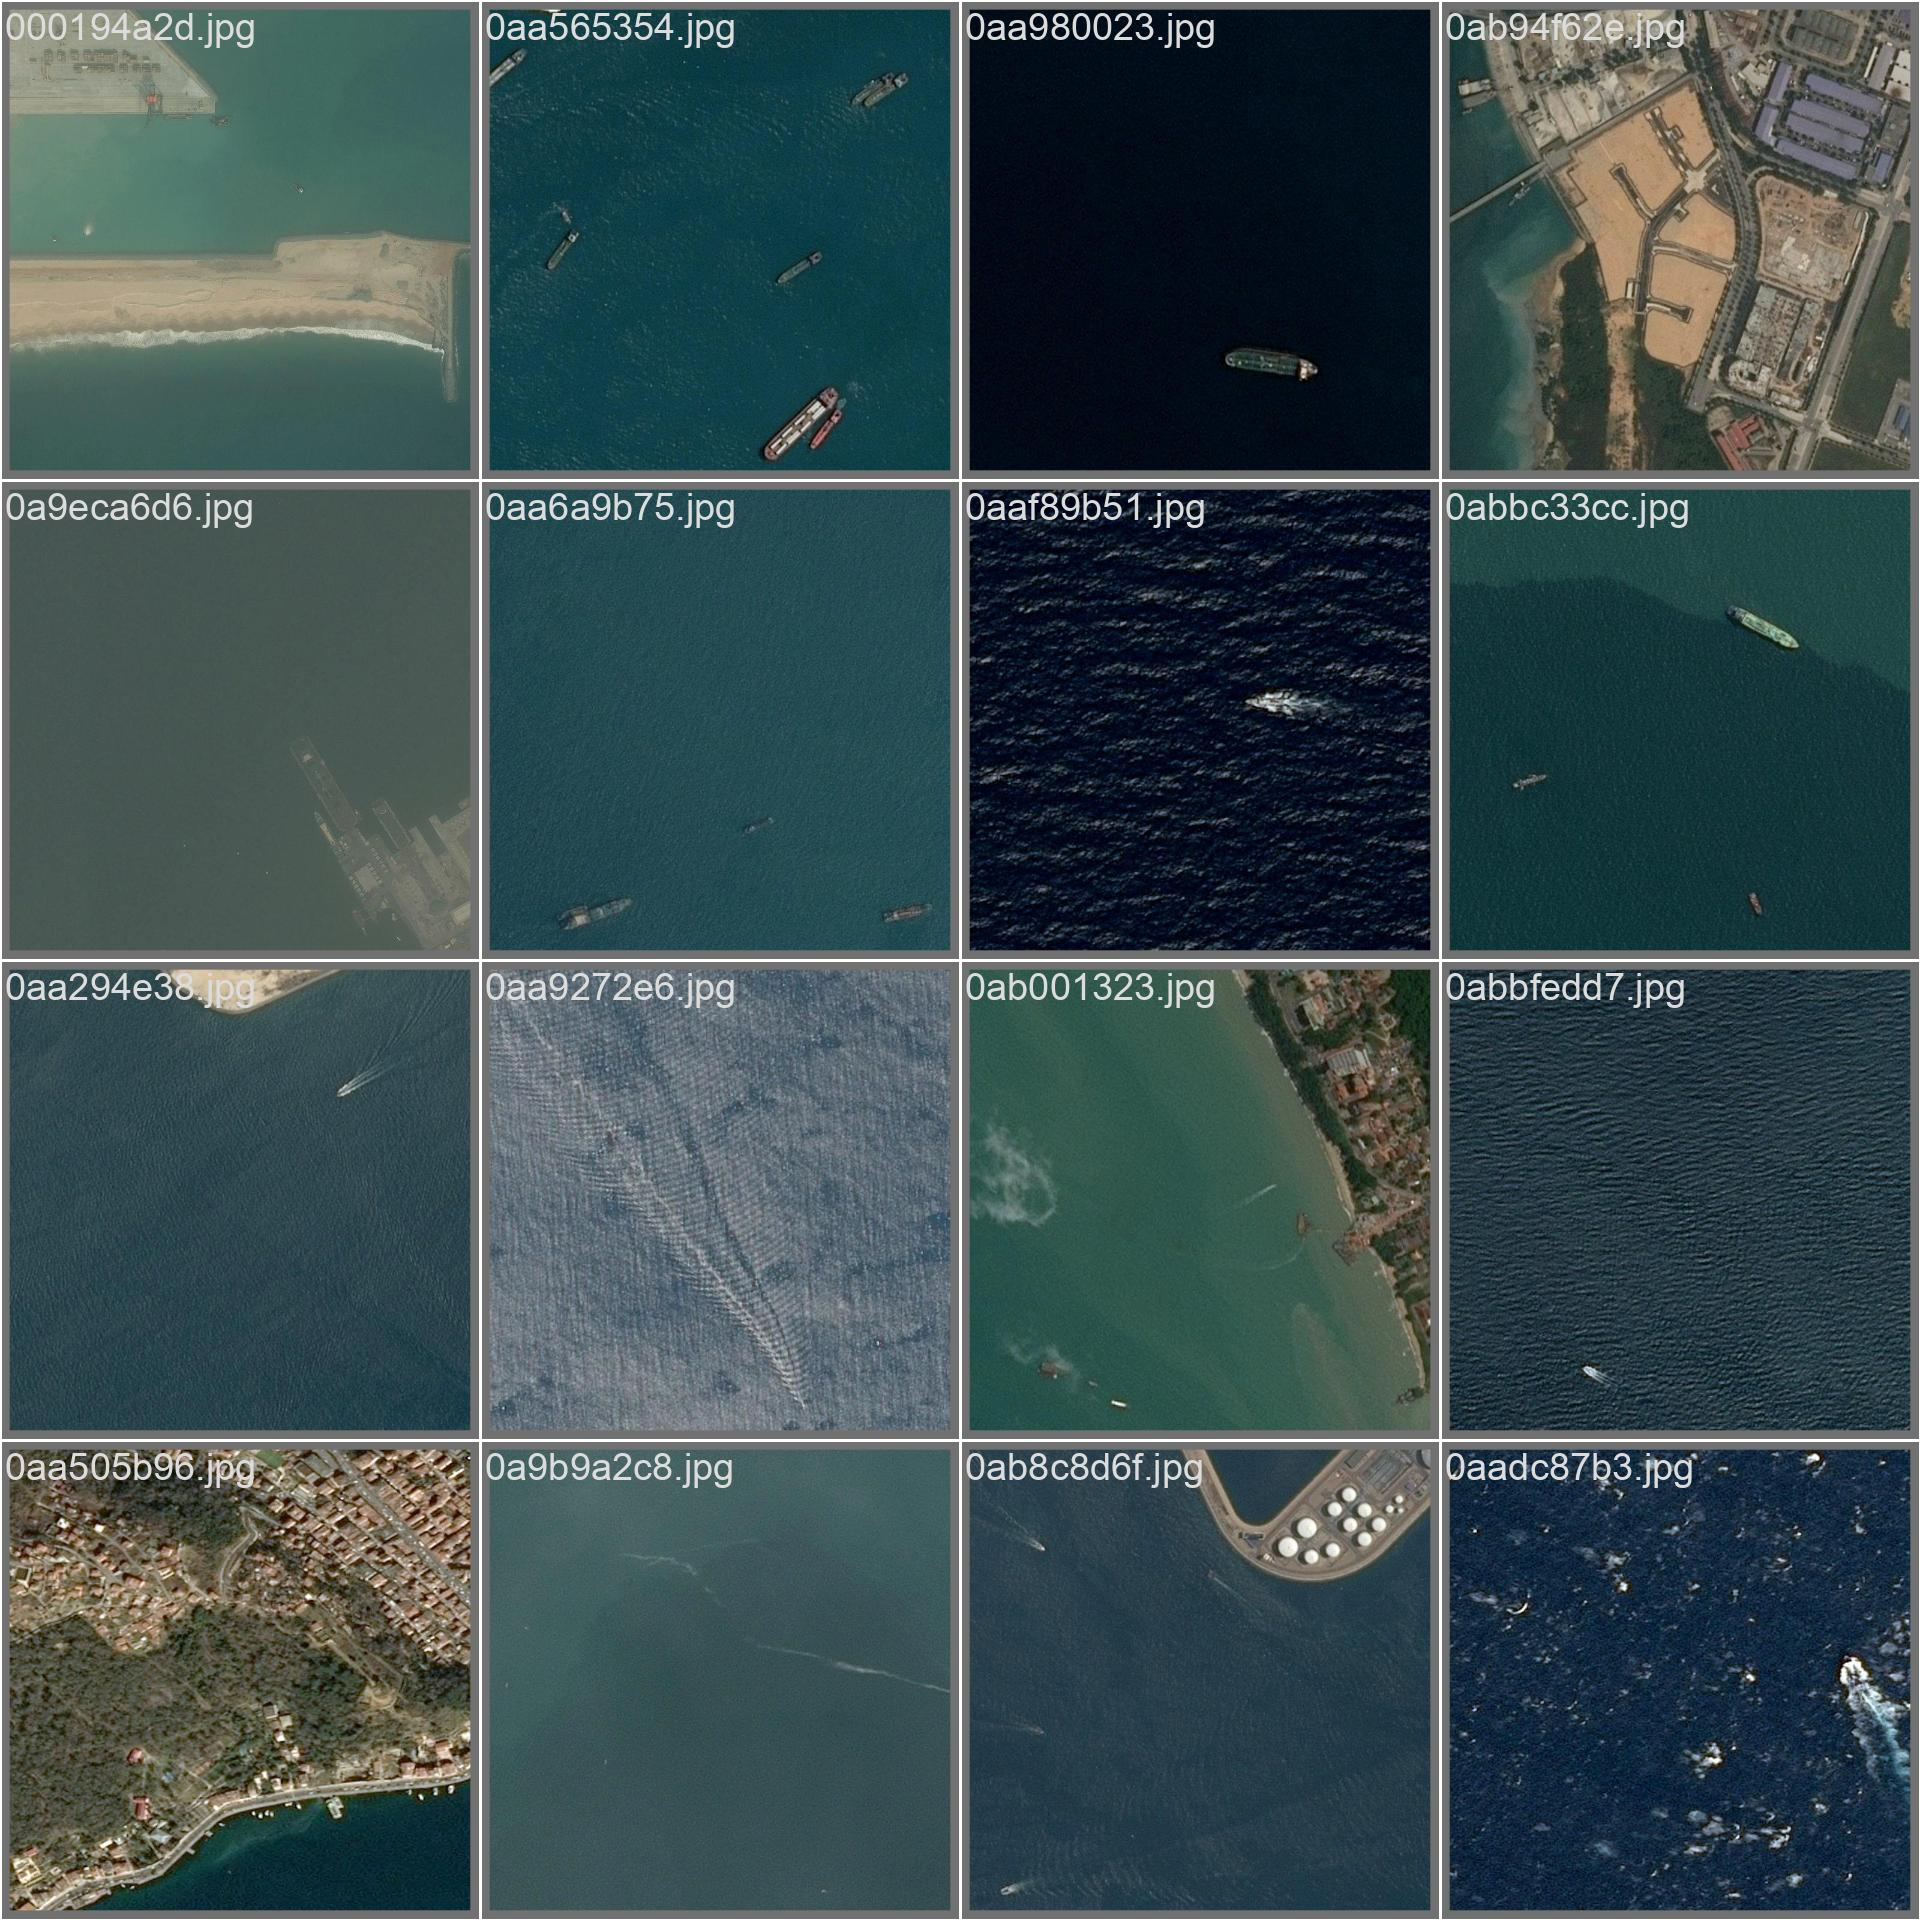

In [ ]:
from IPython.display import Image, display

# Display images with predictions for a specific batch
print("train_batch0.jpg")
display(Image(filename='/content/runs/segment/train/train_batch0.jpg', width=600))
print("val_batch0_labels.jpg")
display(Image(filename='/content/runs/segment/train/val_batch0_labels.jpg', width=600))
print("val_batch0_pred.jpg")
display(Image(filename='/content/runs/segment/train/val_batch0_pred.jpg', width=600))